In [1]:
! ls -rlta

total 6629208
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users    569231 Mar 24  2013 joda-time-2.0.jar
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users 121249243 Aug 22  2014 2007.csv.bz2.1
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users 121249243 Aug 22  2014 2007.csv.bz2
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users 702878193 Aug 22  2014 2007.csv
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users 113753229 Dec  9  2014 2008.csv.bz2.1
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users 113753229 Dec  9  2014 2008.csv.bz2
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users 689413344 Dec  9  2014 2008.csv
drwx------ 11 s7ed-a18f3badb92bc2-a9f6794a31ec users      4096 Jul 20 06:55 ..
drwx------  2 s7ed-a18f3badb92bc2-a9f6794a31ec users      4096 Aug  2 03:08 joda
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users      1553 Aug  2 04:00 preprocess1.pig
-rw-------  1 s7ed-a18f3badb92bc2-a9f6794a31ec users     30139 Aug  3 05:45 2007-ord-weather-data.csv
-rw-----

In [2]:
# For SQL-type queries (Spark)
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

# For regression and other possible ML tools (Spark)
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics


# Important for managing features  (Spark)
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler

# For displaying and other related IPython tools...
from IPython.display import display
from IPython.html.widgets import interact

# Typycal Python tools
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# We now create a SQL DataFrame, this entity is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in Python, but with richer optimizations under the hood. We will utilize the recently created Spark RDD and use the Spark SQL context to create the desired data frame,

# We first create function that will allow to parse a record of our RDD into the desired format. As a reference we take a look at features_names and feature_example we just created above

def parse(r):
    try:
        x=Row(Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          CRSDepTime=int(r[5]),\
          DepDelay=int(float(r[15])),\
          Origin=r[16],\
          Dest=r[17], \
          Distance=int(float(r[18]))) 
    except:
        x=None  
    return x

# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h
# register as a UDF 
f = udf(hour_ex, IntegerType())

In [4]:
def prepFlightDelay(airfile, orgn):
    textFile = sc.textFile(airfile)
    textFileRDD = textFile.map(lambda x: x.split(','))
    header = textFileRDD.first()
    textRDD = textFileRDD.filter(lambda r: r != header)
    rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
    airline_df = sqlContext.createDataFrame(rowRDD)
    airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))
    airline_df.registerTempTable("airlineDF")
    airline_df_orgn = airline_df.filter((col("Origin") == orgn))
    airline_df_orgn_15 = airline_df_orgn.withColumn('DepDelayed', (airline_df_orgn['DepDelay']>15).cast(DoubleType()))
    return airline_df_orgn_15

In [5]:
def prepWeather(wfile):
    df = sqlContext.read.csv(wfile, header=True)
    df_parse = df.drop('STATION', 'NAME')
    df_parse1 = df_parse.withColumn("DATE", regexp_replace('DATE', '/', '-'))
    df_parse2 = df_parse1.withColumn("AWND", df_parse1["AWND"].cast("Int"))
    df_parse3 = df_parse2.withColumn("PRCP", df_parse2["PRCP"].cast("Int"))
    df_parse4 = df_parse3.withColumn("SNOW", df_parse3["SNOW"].cast("Int"))
    df_parse5 = df_parse4.withColumn("TMAX", df_parse4["TMAX"].cast("Int"))
    df_parse6 = df_parse5.withColumn("TMIN", df_parse5["TMIN"].cast("Int"))
    df_month = df_parse6.withColumn("Month", split(df_parse6.DATE, "-")[0].cast("Int"))
    df_day = df_month.withColumn("DayofMonth", split(df_month.DATE, "-")[1].cast("Int"))
    df_weather = df_day.drop('DATE')
    return df_weather

In [6]:
def preprocessing (airfile,wfile,org):
    airline_delay_org = prepFlightDelay(airfile,org)
    airlinedelay_pd_df = airline_delay_org.toPandas()
    df_weather = prepWeather(wfile)
    weather_pd_df = df_weather.toPandas()
    airdelay_weather = pd.merge(airlinedelay_pd_df,weather_pd_df,how='right', left_on=['Month','DayofMonth'], right_on = ['Month','DayofMonth'])
    airdelay_pred = sqlContext.createDataFrame(airdelay_weather)
    return airdelay_pred

In [7]:
flight_delay_2007 = preprocessing ("2007.csv","2007-ord-weather-data.csv","ORD")

In [8]:
flight_delay_2007.printSchema()

root
 |-- CRSDepTime: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DepDelay: long (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Origin: string (nullable = true)
 |-- hour: long (nullable = true)
 |-- DepDelayed: double (nullable = true)
 |-- AWND: long (nullable = true)
 |-- PRCP: long (nullable = true)
 |-- SNOW: long (nullable = true)
 |-- TMAX: long (nullable = true)
 |-- TMIN: long (nullable = true)



In [9]:
flight_delay_2007.dtypes

[('CRSDepTime', 'bigint'),
 ('DayOfWeek', 'bigint'),
 ('DayofMonth', 'bigint'),
 ('DepDelay', 'bigint'),
 ('Dest', 'string'),
 ('Distance', 'bigint'),
 ('Month', 'bigint'),
 ('Origin', 'string'),
 ('hour', 'bigint'),
 ('DepDelayed', 'double'),
 ('AWND', 'bigint'),
 ('PRCP', 'bigint'),
 ('SNOW', 'bigint'),
 ('TMAX', 'bigint'),
 ('TMIN', 'bigint')]

In [10]:
flight_delay_2008 = preprocessing ("2008.csv","2008-ord-weather-data.csv","ORD")

In [11]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, OneHotEncoder, StandardScaler, StandardScalerModel, VectorSlicer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline, Model

In [12]:
#predict_label = StringIndexer(inputCol="DepDelayed", outputCol="label").fit(flight_delay_2007)
#predict_label_df = predict_label.transform(flight_delay_2007)
#predict_label_df.show()

In [13]:
#str_dest = StringIndexer(inputCol="Dest", outputCol="Destination").fit(flight_delay_2007)
#str_dest_df = str_dest.transform(flight_delay_2007)
#str_dest_df.show()

In [14]:
#encoder = OneHotEncoder(inputCol="Destination", outputCol="Dest_vector")
#encoded_df = encoder.transform(str_dest_df)
#encoded_df.show()

In [15]:
#inputColumns = ["hour","DayOfWeek","DayofMonth","DepDelay","Distance","Month","AWND","PRCP","SNOW","TMAX","TMIN","Dest_vector"]
#assembler = VectorAssembler(inputCols=inputColumns, outputCol="rawfeatures")
#encoded_df_with_indexed_bar = assembler.transform(encoded_df)
#encoded_df_with_indexed_bar.show()

In [16]:
#scaler = StandardScaler(inputCol="rawfeatures", outputCol="features", withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
#scalerModel = scaler.fit(encoded_df_with_indexed_bar)
# Normalize each feature to have unit standard deviation.
#scaledData = scalerModel.transform(encoded_df_with_indexed_bar)
#scaledData.select("features").take(5)

In [17]:
#predict_label = StringIndexer(inputCol="DepDelayed", outputCol="label").fit(scaledData)
#predict_label_df = predict_label.transform(scaledData)
#predict_label_df.show()

In [18]:
def ml_preprocess(dataset):
    pipeline_stages = [] # stages in our Pipeline
    
    #str_dest = StringIndexer(inputCol="Dest", outputCol="Destination").fit(dataset)
    #pipeline_stages += [str_dest]
                        
    #encoder = OneHotEncoder(inputCol="Destination", outputCol="Dest_vector")
    #pipeline_stages += [encoder]
    
    # Transform all features into a vector using VectorAssembler
    #inputColumns = ["hour","DayOfWeek","DayofMonth","DepDelay","Distance","Month","AWND","PRCP","SNOW","TMAX","TMIN","Dest_vector"]
    
    inputColumns = ["hour","DayOfWeek","DayofMonth","DepDelay","Distance","Month","AWND","PRCP","SNOW","TMAX","TMIN"]
    assembler = VectorAssembler(inputCols=inputColumns, outputCol="rawfeatures")
    pipeline_stages += [assembler]
    
    # Compute summary statistics by fitting the StandardScaler
    scaler = StandardScaler(inputCol="rawfeatures", outputCol="features", withStd=True, withMean=False)
    pipeline_stages += [scaler]
    
    # Convert label into label indices using the StringIndexer
    predict_label = StringIndexer(inputCol="DepDelayed", outputCol="label")
    pipeline_stages += [predict_label]

    
    # Create a Pipeline.
    pipeline = Pipeline(stages=pipeline_stages)

    # Run the feature transformations.
    #  - fit() computes feature statistics as needed.
    #  - transform() actually transforms the features.
    pipelineModel = pipeline.fit(dataset)
    processed_dataset = pipelineModel.transform(dataset)
    
    return processed_dataset

In [19]:
training_data_2007 = ml_preprocess(flight_delay_2007)
testing_data_2008 = ml_preprocess(flight_delay_2008)

In [20]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(training_data_2007)

In [21]:
lrPredictions = lrModel.transform(testing_data_2008)

In [22]:
# Build a Confusion Matrix
lp = lrPredictions.select( "label", "prediction")
counttotal = lrPredictions.count()


tp = lp[(lp.label == 1) & (lp.prediction == 1)].count()
tn = lp[(lp.label == 0) & (lp.prediction == 0)].count()
fp = lp[(lp.label == 0) & (lp.prediction == 1)].count()
fn = lp[(lp.label == 1) & (lp.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
print ("Total", lp.count())

r = float(tp)/(tp + fn)
print ("recall", r)

p = float(tp) / (tp + fp)
print ("precision", p)


print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

True Positives: 90894
True Negatives: 241108
False Positives: 1463
False Negatives: 1975
Total 335440
recall 0.9787334848011715
precision 0.9841592949099689
Coefficients: [-0.3678499133512859,-0.09437739814238613,-0.09935150115794421,14.935835185306226,-0.067094064160487,-0.18106322132157182,-0.40356500187582595,-0.03257932452584976,-0.16653294800058627,-0.6997083468438263,0.4704541369660158]
Intercept: -1.8298029174121397


In [23]:
import numpy as np
cm_results = np.array([[tp,fn],[fp,tn]])
cm_results

array([[ 90894,   1975],
       [  1463, 241108]])

In [24]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

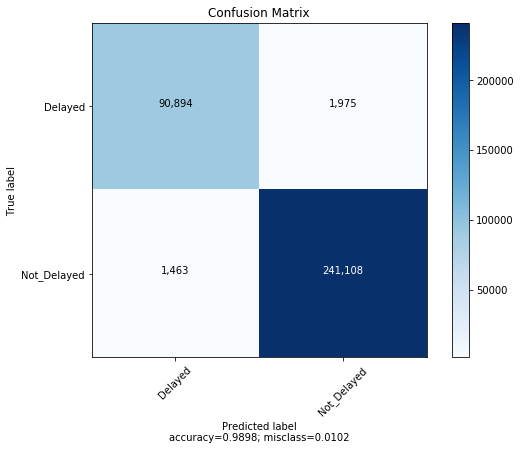

In [25]:
plot_confusion_matrix(cm           = cm_results, 
                      normalize    = False,
                      target_names = ['Delayed', 'Not_Delayed'],
                      title        = "Confusion Matrix")

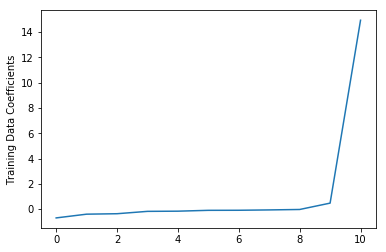

In [26]:
#%spark2.pyspark
##### We can obtain the coefficients by using LogisticRegressionModel’s attributes.
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Training Data Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
lrModel.summary

In [ ]:
# Precision and Recall

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
lrPredictions.printSchema()
lr_prediction_df = lrPredictions.toPandas()